In [8]:
import snntorch as snn
from snntorch import spikeplot as splt
from snntorch import spikegen
from snntorch import utils

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

import matplotlib.pyplot as plt
import numpy as np

In [9]:
# DataLoader Arguments
batch_size = 128
data_path = '/data/mnist'

dtype = torch.float
#device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

# Select Dataset and define Transform
transform = transforms.Compose([transforms.Resize((10, 10)),
                                transforms.Grayscale(),
                                transforms.ToTensor(),
                                transforms.Normalize((0,), (1,))])

mnist_train = datasets.MNIST(data_path, train=True, download=True, transform=transform)
indices = (mnist_train.targets == 0) | (mnist_train.targets == 1) | (mnist_train.targets == 2) | (mnist_train.targets == 3) 
mnist_train.data, mnist_train.targets = mnist_train.data[indices], mnist_train.targets[indices]

mnist_test = datasets.MNIST(data_path, train=False, download=True, transform=transform)
indices = (mnist_test.targets == 0) | (mnist_test.targets == 1) | (mnist_test.targets == 2) | (mnist_test.targets == 3) 
mnist_test.data, mnist_test.targets = mnist_test.data[indices], mnist_test.targets[indices]

print(f"The size of train_set is {len(mnist_train)}")    # 24754
print(f"The size of test_set is {len(mnist_test)}")      # 4157

# Create DataLoaders, load multiple samples up into memory in batches
train_loader = DataLoader(mnist_train, batch_size=batch_size, shuffle=True, drop_last=True)
test_loader = DataLoader(mnist_test, batch_size=batch_size, shuffle=True, drop_last=True)

The size of train_set is 24754
The size of test_set is 4157


In [10]:
# Network Architecture
num_inputs = 10*10  
num_hidden = 200
num_outputs = 4   # 4 outputs classes: 0, 1, 2, 3

# Temporal Dynamics
num_steps = 10      # run for 10 time steps
beta = 0.95 

# Define the network
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        
        # Initialize layers
        # Neuron input: Spik_in W x X[t] and U[t-1], Neuron output: Spike S[t] and U[t]
        self.lif1 = snn.Leaky(beta=beta, threshold=0.001)  # Threshold=0.001: each raw image pixel value greater than 0 corresponds to a spike
        self.fc1 = nn.Linear(num_inputs, num_hidden)
        self.lif2 = snn.Leaky(beta=beta, threshold=0.1)  
        self.fc2 = nn.Linear(num_hidden, num_outputs)
        self.lif3 = snn.Leaky(beta=beta, threshold=0.7)
        
    def forward(self, x):
        
        # Initialize hidden states at t=0
        mem1 = self.lif1.init_leaky()
        mem2 = self.lif2.init_leaky()
        mem3 = self.lif3.init_leaky()
        
        # Record the finial laye
#         spk1_rec = []
#         mem1_rec = []
#         spk2_rec = []
#         mem2_rec = []
        spk3_rec = []
        mem3_rec = []
        
        for step in range(num_steps):
            spk1, mem1 = self.lif1(x, mem1)            # analog signal --> spike X[t]
            cur1 = self.fc1(spk1)                   # X[t] x weight --> post-synaptic current
            spk2, mem2 = self.lif2(cur1, mem2)   # post-syn current + decayed membrane --> mem[t+1]
            cur2 = self.fc2(spk2)
            spk3, mem3 = self.lif2(cur2, mem3)
            spk3_rec.append(spk3)
            mem3_rec.append(mem3)
        
        # Convert lists to tensors: Concatenates a sequence of tensors along a new dimension(time).
        return torch.stack(spk3_rec, dim=0), torch.stack(mem3_rec, dim=0)

In [11]:
# pass data into the network, sum the spikes_output over time and compare the neuron with the highest number of spikes with the target
def print_batch_accuracy(data, targets, train=True):
    output, _ = net(data.view(batch_size, -1))
    _, idx = output.sum(dim=0).max(1)                       # max(1):return the max value and indices of each row
    acc = np.mean((targets == idx).detach().cpu().numpy())
    
    if train:
        print(f"Train set accuracy for single nminibatch: {acc*100: .2f}%")
    else:
        print(f"Test set accuracy for single nminibatch: {acc*100: .2f}%")
    return acc*100

In [12]:
net = Net()
net.load_state_dict(torch.load('new5_model.pt'), strict=False)   # strict=False: ignore non-matching keys

<All keys matched successfully>

In [13]:
# ### Test set accuracy

total = 0
correct = 0

# drop_last switched to False to keep all samples
test_loader = DataLoader(mnist_test, batch_size=batch_size, shuffle=True, drop_last=False)

with torch.no_grad():
    net.eval()
    for data, targets in test_loader:
        # forward pass
        test_spk, _ = net(data.view(data.size(0), -1))

        # calculate total accuracy
        _, predicted = test_spk.sum(dim=0).max(1)
        total += targets.size(0)
        correct += (predicted == targets).sum().item()
        
print(f"Total correctly classified test set images: {correct}/{total}")
print(f"Test Set Accuracy: {100 * correct / total:.2f}%")

Total correctly classified test set images: 3820/4157
Test Set Accuracy: 91.89%


In [14]:
# Weight_1
weight_1 = net.fc1.weight.cpu().data.numpy()
print('weight_1:\n', weight_1)
print(weight_1.shape)

weight_1:
 [[ 0.04440596 -0.04431878  0.00676954 ... -0.10348185 -0.09468162
   0.14076482]
 [-0.02589911 -0.11512322  0.07800575 ...  0.01528476 -0.1331128
  -0.02281439]
 [ 0.14272605  0.14561492  0.06957025 ... -0.01889863 -0.02328132
   0.00316831]
 ...
 [ 0.05831295 -0.06286907  0.03868384 ...  0.04255121  0.05437662
   0.15872076]
 [ 0.07700018 -0.04647473 -0.08036742 ...  0.01325437 -0.10500916
   0.06363854]
 [ 0.00324391 -0.00124407  0.09694409 ...  0.02378646 -0.02473303
  -0.06871624]]
(200, 100)


In [15]:
print(weight_1.max())
print(weight_1.min())

0.38310325
-0.553871


In [16]:
# Bias_1
bias_1 = net.fc1.bias.cpu().data.numpy()
print('bias_1:\n', bias_1)
print(bias_1.shape)

bias_1:
 [ 2.11594757e-02 -8.22503492e-02 -7.73365749e-03 -2.93175876e-02
  1.63539425e-02 -3.55763137e-02  5.44764567e-03 -8.51864964e-02
  2.68626362e-02  7.16835912e-03  2.28813500e-03 -8.97551104e-02
  3.08638457e-02  2.75142603e-02  1.90980546e-02 -7.12632388e-02
 -3.74383740e-02 -5.92031814e-02 -5.48712537e-02 -1.45891055e-01
 -2.32959129e-02  6.73231259e-02  2.26747915e-02 -7.26466030e-02
  7.38553479e-02 -1.23693854e-01  7.24542737e-02 -1.71334743e-02
 -5.10120243e-02 -6.12348020e-02  2.95415875e-02  4.19766977e-02
 -5.06187826e-02 -2.70874314e-02  7.08060190e-02  6.60267025e-02
 -8.49639326e-02 -1.04638143e-02  7.59899393e-02 -4.63637635e-02
  3.95564139e-02  9.21716392e-02 -2.64153257e-03 -5.28923608e-02
 -9.64610055e-02  7.14629069e-02 -9.96190980e-02 -1.71174482e-02
 -7.63105676e-02  4.47974075e-03  1.09295763e-01  4.84078266e-02
  4.01792750e-02 -7.88929164e-02  7.63962567e-02 -3.00156288e-02
 -3.49527858e-02 -1.23522416e-01 -7.47884437e-02 -5.22768684e-02
 -1.15718124e-02

In [17]:
# Bias_1
bias_1 = net.fc1.bias.data
print('bias_1:\n', bias_1)
print(bias_1.shape)

bias_1:
 tensor([ 2.1159e-02, -8.2250e-02, -7.7337e-03, -2.9318e-02,  1.6354e-02,
        -3.5576e-02,  5.4476e-03, -8.5186e-02,  2.6863e-02,  7.1684e-03,
         2.2881e-03, -8.9755e-02,  3.0864e-02,  2.7514e-02,  1.9098e-02,
        -7.1263e-02, -3.7438e-02, -5.9203e-02, -5.4871e-02, -1.4589e-01,
        -2.3296e-02,  6.7323e-02,  2.2675e-02, -7.2647e-02,  7.3855e-02,
        -1.2369e-01,  7.2454e-02, -1.7133e-02, -5.1012e-02, -6.1235e-02,
         2.9542e-02,  4.1977e-02, -5.0619e-02, -2.7087e-02,  7.0806e-02,
         6.6027e-02, -8.4964e-02, -1.0464e-02,  7.5990e-02, -4.6364e-02,
         3.9556e-02,  9.2172e-02, -2.6415e-03, -5.2892e-02, -9.6461e-02,
         7.1463e-02, -9.9619e-02, -1.7117e-02, -7.6311e-02,  4.4797e-03,
         1.0930e-01,  4.8408e-02,  4.0179e-02, -7.8893e-02,  7.6396e-02,
        -3.0016e-02, -3.4953e-02, -1.2352e-01, -7.4788e-02, -5.2277e-02,
        -1.1572e-02, -4.0388e-04, -1.1815e-01, -6.2017e-02,  9.8013e-02,
        -7.2563e-03, -2.2313e-02,  1.0194e

In [18]:
# Weight_2
weight_2 = net.fc2.weight.cpu().data.numpy()
print('weight_2:\n', weight_2)
print(weight_2.shape)

weight_2:
 [[ 7.65676945e-02  1.48739502e-01  5.65794334e-02 -2.44567290e-01
   5.43335490e-02  1.05430566e-01  2.78049875e-02 -3.92085388e-02
   4.10610251e-02 -3.92942429e-02 -1.75673500e-01  1.82195649e-01
   1.43997401e-01  1.44617138e-02 -9.16993245e-02  2.19564252e-02
   5.69887944e-02  5.81580140e-02 -1.13868555e-02  3.30396146e-01
   1.16553403e-01 -2.34557875e-02 -1.63604930e-01  1.17194697e-01
   2.73185894e-02  9.62623283e-02 -2.24154711e-01 -1.52521893e-01
  -3.03793788e-01  1.64125890e-01  3.98651809e-02  2.09941357e-01
  -2.65313685e-02 -2.42723614e-01 -1.62645742e-01 -1.25989154e-01
   4.52854261e-02 -2.14279726e-01  1.02394864e-01 -2.56049126e-01
   1.17857024e-01 -5.49709350e-02 -5.96256778e-02 -6.93769604e-02
   5.67515157e-02  1.73488691e-01  5.45585155e-02 -8.52713957e-02
   1.43441500e-03 -3.48857827e-02  2.75069103e-02  5.47590069e-02
   7.24802166e-02 -4.73238155e-03  1.09809026e-01 -3.34451646e-01
   6.95645735e-02  7.13787749e-02  4.19652415e-03 -1.01949938e-01

In [19]:
print(weight_2.max())
print(weight_2.min())

0.56936836
-0.46473905


In [20]:
# Bias_2
bias_2 = net.fc2.bias.cpu().data.numpy()
print('bias_2:\n', bias_2)
print(bias_2.shape)

bias_2:
 [ 0.1240624  -0.0872117  -0.05303128  0.02563431]
(4,)


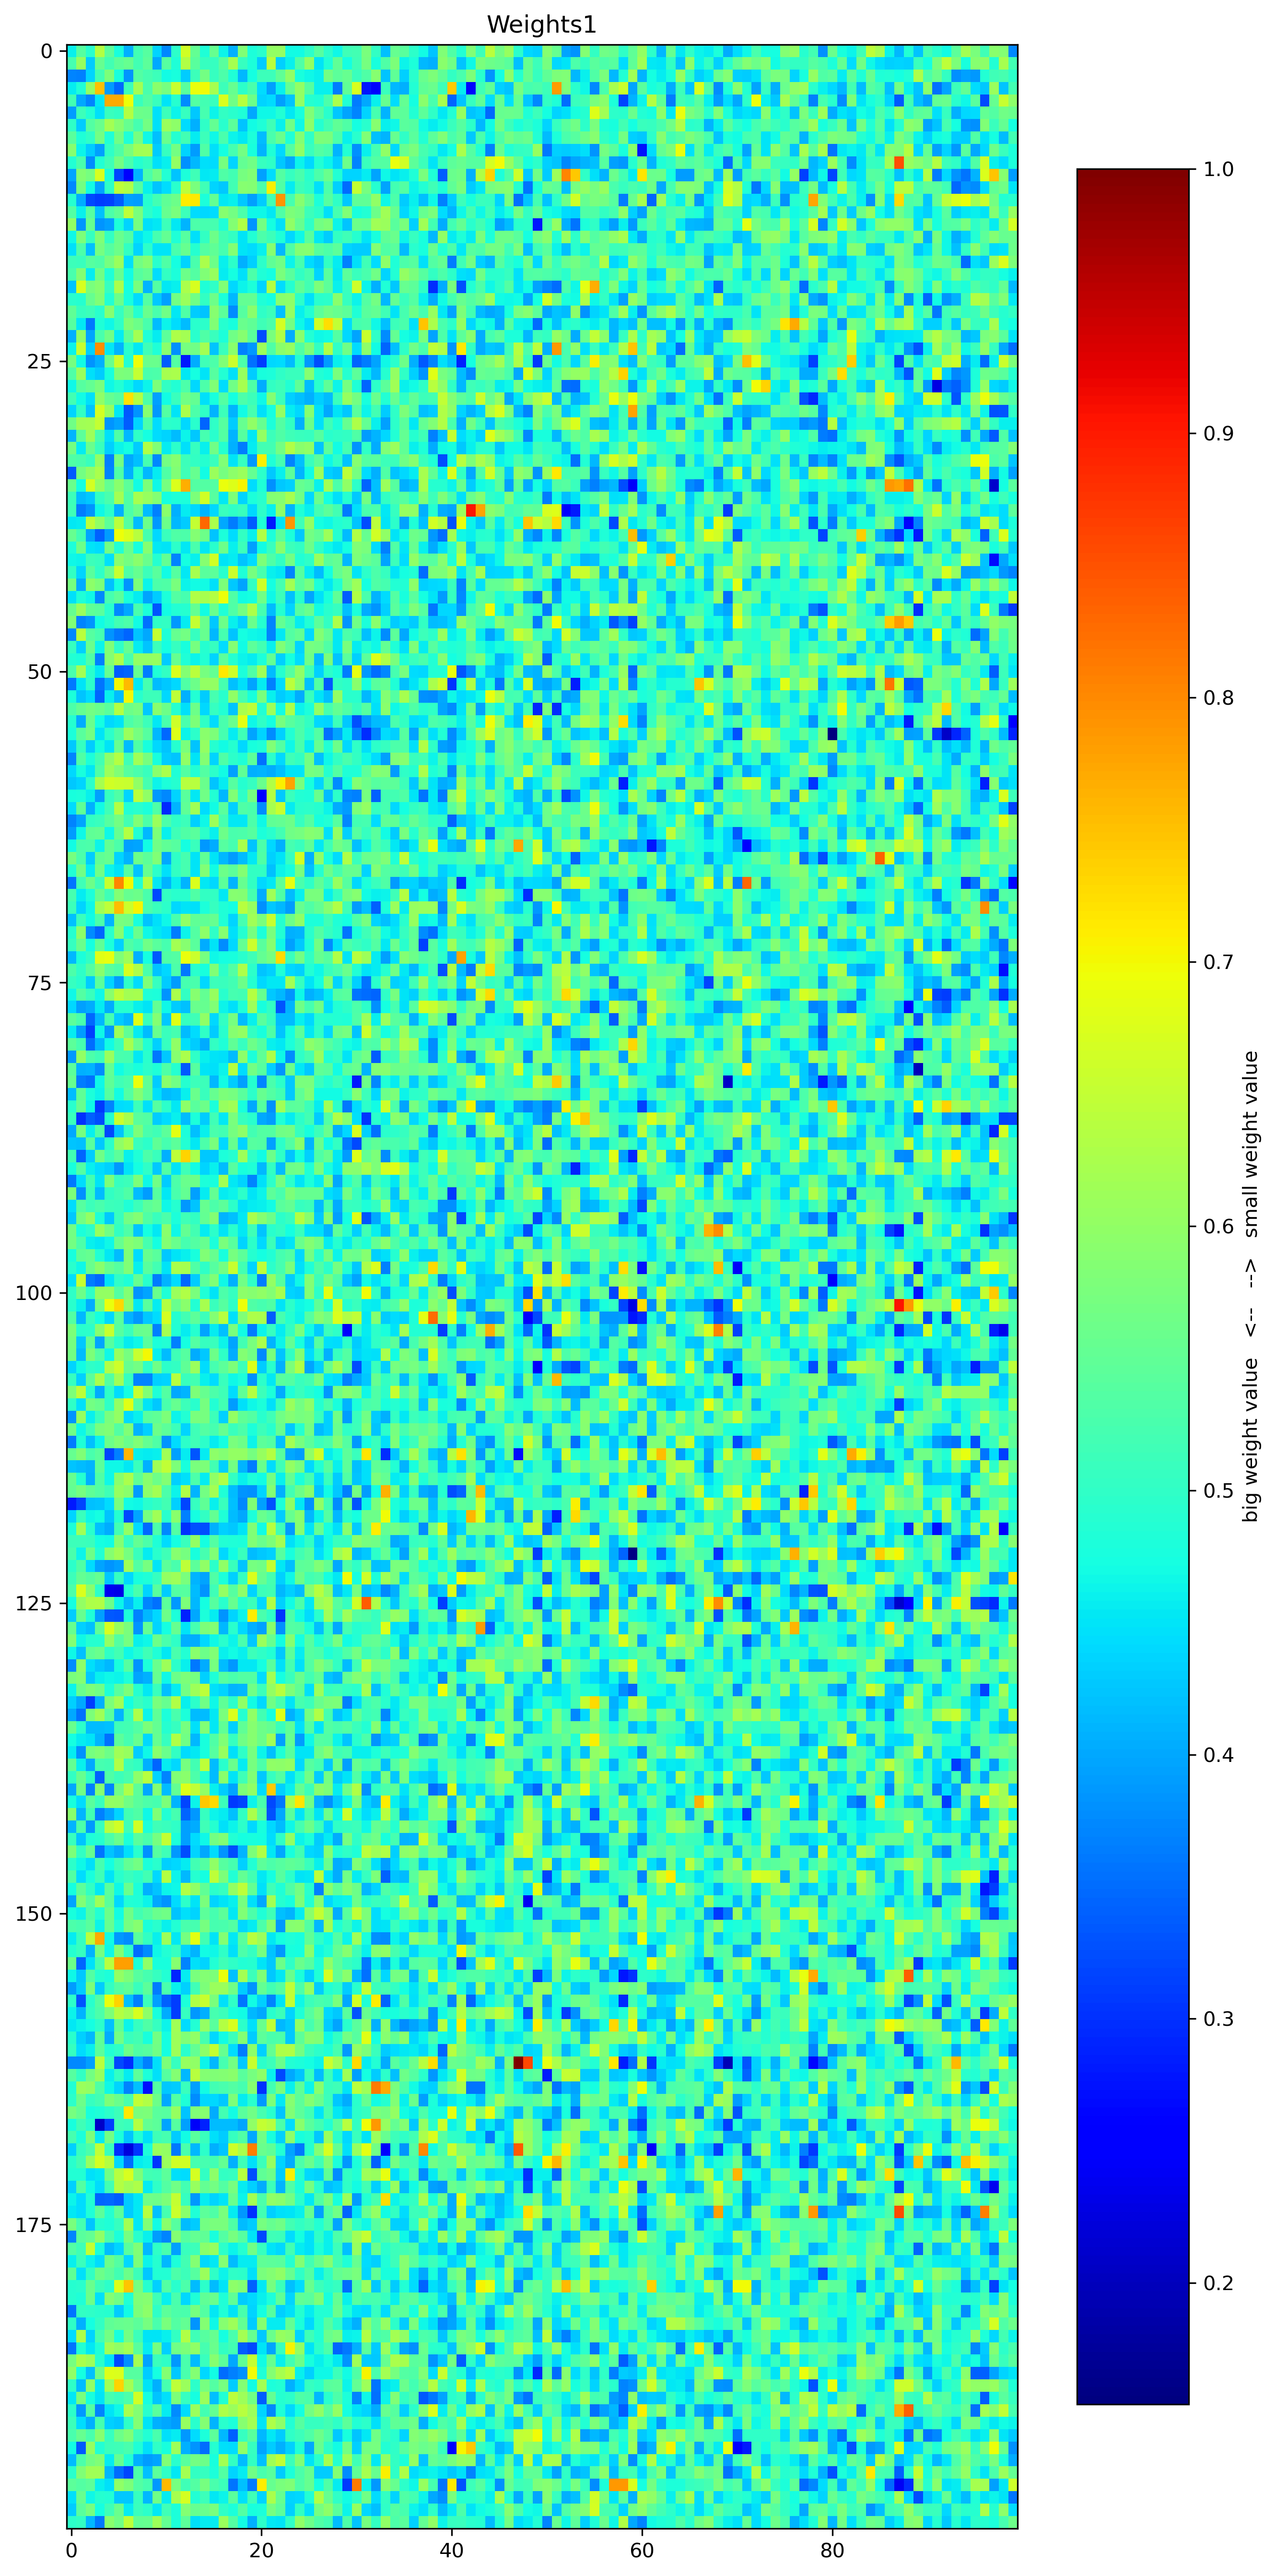

In [59]:
### Plot weights
fig, ax = plt.subplots(1, 1, figsize=(9, 18))       # Width, height in inches

weights1 = net.fc1.weight.cpu().data.numpy()
weights1_scaled = (1/(2*np.min(weights1)))*weights1 + 0.5

im = plt.imshow(weights1_scaled, cmap='jet', aspect='auto')
ax.set_title('Weights1')

# plt.xlim((1, 100))
# plt.ylim((1, 200))
# Add a colorbar to a plot
#plt.colorbar(im, orientation='vertical', label='big   <--   -->   small')
cbar = fig.colorbar(im, shrink=0.9, ax=ax)
cbar.set_label('big weight value   <--   -->   small weight value')
# plt.axis('off')

# ## Method 2
# im = ax.imshow(weights1_scaled, cmap='jet')
# ax.set_title('Weights1')
# # Add a colorbar to a plot
# cbar = fig.colorbar(im, ax=ax)
# cbar.set_label('big --> small')

### Methode 3
# cs = ax.contourf(weights1_scaled, cmap='jet')
# cbar = fig.colorbar(cs)

plt.tight_layout()
plt.savefig('weights1.png', bbox_inches='tight')
plt.show()

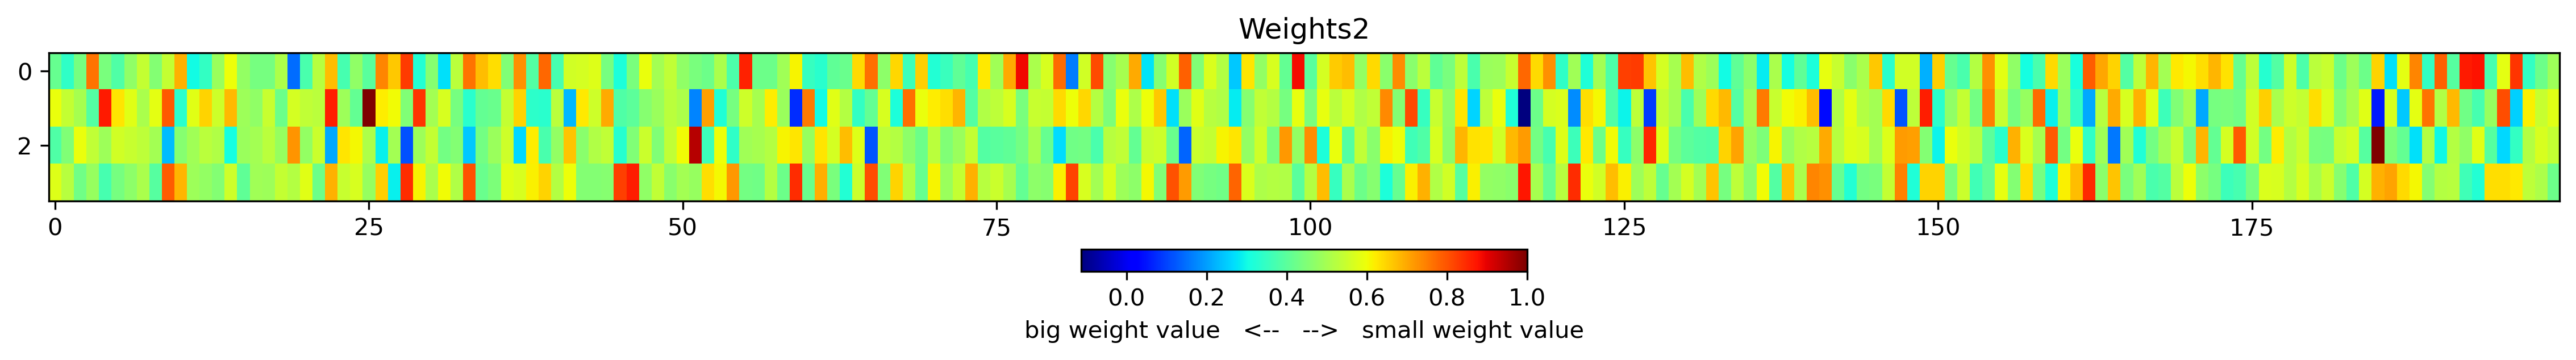

In [61]:
### Plot weights
fig, ax = plt.subplots(1, 1, figsize=(15,2), constrained_layout=True)       # Width, height in inches

weights2 = net.fc2.weight.cpu().data.numpy()
weights2_scaled = (1/(2*np.min(weights2)))*weights2 + 0.5

im = plt.imshow(weights2_scaled, cmap='jet', aspect='auto')
ax.set_title('Weights2')

# Add a colorbar to a plot
plt.colorbar(im, orientation='horizontal', label='big weight value   <--   -->   small weight value')
# cbar = fig.colorbar(im, shrink=0.9, ax=ax)
# cbar.set_label('big weight value<-->small weight value')

# ## Method 2
# im = ax.imshow(weights1_scaled, cmap='jet')
# ax.set_title('Weights1')
# # Add a colorbar to a plot
# cbar = fig.colorbar(im, ax=ax)
# cbar.set_label('big --> small')

### Methode 3
# cs = ax.contourf(weights1_scaled, cmap='jet')
# cbar = fig.colorbar(cs)

# plt.tight_layout()
plt.savefig('weights2.png', bbox_inches='tight')
plt.show()